# ANOVA

When comparing more than two groups, calculating t-tests for each pair is cumbersome and increase the risk of missing significant results. So...ANOVA

## One-Way ANOVA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
np.random.seed(12)

races = ["asian","black","hispanic","other","white"]
race_prop = [0.05,0.15,0.25,0.05,0.5]

voter_race = np.random.choice(a=races, p=race_prop, size=1000)

voter_age = stats.poisson.rvs(loc=18, mu=30, size=1000)

voter_frame = pd.DataFrame({"race":voter_race, "age":voter_age})

groups = voter_frame.groupby("race").groups

asian = voter_age[groups["asian"]]
black = voter_age[groups["black"]]
hispanic = voter_age[groups["hispanic"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

stats.f_oneway(asian, black, hispanic, other, white)

F_onewayResult(statistic=1.7744689357329695, pvalue=0.13173183201930463)



The test output yields an F-statistic of 1.774 and a p-value of 0.1317, indicating that there is no significant difference between the means of each group.

Another way to carry out an ANOVA test is to use the statsmodels library, which allows you to specify a model with a formula syntax that mirrors that used by the R programming language. R users may find this method more familiar:


In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('age ~ race',
            data=voter_frame).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)

             sum_sq     df         F    PR(>F)
race        199.369    4.0  1.774469  0.131732
Residual  27948.102  995.0       NaN       NaN


**Test where group means do differ**

In [7]:
np.random.seed(12)

races = ["asian","black","hispanic","other","white"]
race_prop = [0.05,0.15,0.25,0.05,0.5]

voter_race = np.random.choice(a=races, p=race_prop, size=1000)

white_ages = stats.poisson.rvs(loc=18, mu=32, size=1000)

voter_age = stats.poisson.rvs(loc=18, mu=30, size=1000)

voter_age = np.where(voter_race == "white", white_ages, voter_age)

voter_frame = pd.DataFrame({'race':voter_race, 'age':voter_age})
groups = voter_frame.groupby("race").groups

asian = voter_age[groups["asian"]]
black = voter_age[groups["black"]]
hispanic = voter_age[groups["hispanic"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

stats.f_oneway(asian, black, hispanic, other, white)

F_onewayResult(statistic=10.164699828386366, pvalue=4.5613242113994585e-08)

In [8]:
model = ols('age ~ race', data=voter_frame).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)

                sum_sq     df        F        PR(>F)
race       1284.123213    4.0  10.1647  4.561324e-08
Residual  31424.995787  995.0      NaN           NaN


The p value and F value suggest significant results. To narrow it to specific categories, perform post-hoc testing

In [9]:
race_pairs = []

for race1 in range(4):
    for race2 in range(race1+1,5):
        race_pairs.append((races[race1], races[race2]))
        
for race1, race2 in race_pairs:
    print(race1, race2)
    print(stats.ttest_ind(voter_age[groups[race1]],
                          voter_age[groups[race2]]))

asian black
TtestResult(statistic=0.8386446909747979, pvalue=0.4027281369339345, df=189.0)
asian hispanic
TtestResult(statistic=-0.42594691924932293, pvalue=0.6704669004240726, df=286.0)
asian other
TtestResult(statistic=0.9795284739636, pvalue=0.3298877500095151, df=92.0)
asian white
TtestResult(statistic=-2.318108811252288, pvalue=0.020804701566400217, df=557.0)
black hispanic
TtestResult(statistic=-1.9527839210712925, pvalue=0.05156197171952594, df=389.0)
black other
TtestResult(statistic=0.28025754367057176, pvalue=0.7795770111117659, df=195.0)
black white
TtestResult(statistic=-5.379303881281834, pvalue=1.0394212166624012e-07, df=660.0)
hispanic other
TtestResult(statistic=1.5853626170340225, pvalue=0.11396630528484335, df=292.0)
hispanic white
TtestResult(statistic=-3.5160312714115376, pvalue=0.0004641298649066684, df=757.0)
other white
TtestResult(statistic=-3.763809322077872, pvalue=0.00018490576317593065, df=563.0)


When multiple comparisons are made, a lower p-value is needed for significance. A simple correction is the Bonferri correction, which simply divides the p-value by the number of comparisons made, in this case 10.

Or use Tukey's test

group1,group2,meandiff,p-adj,lower,upper,reject
asian,black,-0.8032,0.9208,-3.4423,1.836,False
asian,hispanic,0.4143,0.9915,-2.1011,2.9297,False
asian,other,-1.0645,0.8906,-4.2391,2.11,False
asian,white,1.9547,0.1751,-0.4575,4.3668,False
black,hispanic,1.2175,0.2318,-0.386,2.821,False
black,other,-0.2614,0.9986,-2.7757,2.253,False
black,white,2.7579,0.0,1.3217,4.194,True
hispanic,other,-1.4789,0.4374,-3.863,0.9053,False
hispanic,white,1.5404,0.004,0.3468,2.734,True
other,white,3.0192,0.0028,0.7443,5.2941,True


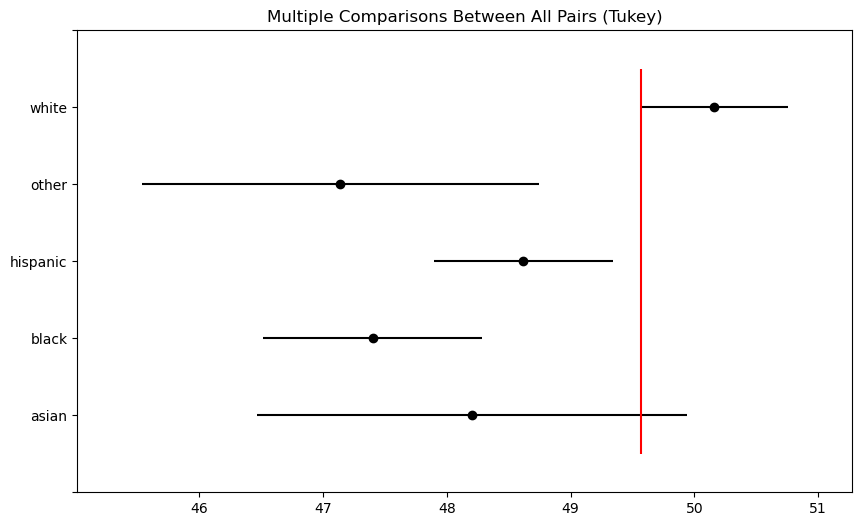

In [10]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=voter_age, groups=voter_race, alpha=0.05)

tukey.plot_simultaneous()
plt.vlines(x=49.57, ymin=-0.5, ymax=4.5, color="red")

tukey.summary()